# Terrascope STAC API
This notebook shows how to interact with the Terrascope STAC API and use it to retrieve data products.

First, we'll load the dependencies.

In [14]:
from pystac_client import Client
from yarl import URL
from pathlib import Path
import pystac
import datetime
import rioxarray
import matplotlib.pyplot as plt

Let's initialize the API client and list the available collections.

In [15]:
client = Client.open("https://stac.terrascope.be")

for collection in client.get_collections():
    print(collection.id)

terrascope-s1-slc-coherence-v1
sentinel-2-l1c
sentinel-2-l2a
terrascope-s2-ccc-v2
terrascope-s2-chl-v1
terrascope-s2-cwc-v2
terrascope-s2-fapar-v2
terrascope-s2-fcover-v2
terrascope-s2-lai-v2
terrascope-s2-ndvi-v2
terrascope-s2-rhow-v1
terrascope-s2-spm-v1
terrascope-s2-toc-v2
terrascope-s2-tur-v1
terrascope-s3-lst-s1-v1
terrascope-s3-lst-s10-v1
terrascope-s3-syn-vgt-s1-v1
terrascope-s3-syn-vgt-s10-v1
esa-worldcover-map-10m-2020-v1
esa-worldcover-ndvi-10m-2020-v1
esa-worldcover-s1vvvhratio-10m-2020-v1
esa-worldcover-s2rgbnir-10m-2020-v1
esa-worldcover-swir-10m-2020-v1
esa-worldcover-map-10m-2021-v2
geoinformed-bosmonitoring
geoinformed-vanggewassen
geoinformed-bwk-sba
geoinformed-watervlakken-maand
geoinformed-bwk
geoinformed-watervlakken-jaar
terrascope-s1-grd-sigma0-v1
sentinel-1-slc
sentinel-1-grd
majorTom-L2A-Flanders
corsa-majorTom-Flanders
esa-worldcover-ndvi-10m-2021-v2
esa-worldcover-s1vvvhratio-10m-2021-v2
esa-worldcover-s2rgbnir-10m-2021-v2
esa-worldcover-swir-10m-2021-v2


We're interested in Sentinel-2 NDVI data and want to search for items for the month of May 2025 for a specific region determined by a bounding box and having less than 10% of cloud cover.

In [16]:
collection = client.get_collection("terrascope-s2-ndvi-v2")
start = datetime.datetime(2025, 5, 1, tzinfo=datetime.timezone.utc)
end = datetime.datetime(2025, 6, 1, tzinfo=datetime.timezone.utc)
bbox = [5.032597, 51.220809, 5.055170, 51.234246]
search = client.search(
    collections=collection.id,
    datetime=[start, end],
    bbox=bbox,
    filter={
        "op": "<=",
        "args": [
            {"property": "properties.eo:cloud_cover"}, 10.0
        ]
    },
)
item_collection = search.item_collection()
item_collection

If we are working on the Terrascope platform itself, we can directly access the data from local storage. These file paths are listed using the [alternate-assets](https://github.com/stac-extensions/alternate-assets) extension at the `alternate.local.href` path.

In [17]:
item_collection.items[0].assets["NDVI"]

<Asset href=https://services.terrascope.be/download/Sentinel2/NDVI_V2/2025/05/16/S2A_20250516T104651_31UFS_NDVI_V210/S2A_20250516T104651_31UFS_NDVI_10M_V210.tif>

Let's check if we have direct access to the local storage or if we need to download the assets first.

In [18]:
local = Path(URL(item_collection.items[0].assets["NDVI"].extra_fields["alternate"]["local"]["href"]).path).exists()

To access the file paths more easily, we can set the alternate link as the main href of the asset.

In [19]:
def set_alternate_asset_href(asset: pystac.Asset, alternate: str):
    """
    Set an alternate href as the main href of the asset.
    :param asset: Asset object
    :param alternate: alternate-asset key
    """
    if (alternates := asset.extra_fields.get("alternate")) and alternate in alternates:
        if alternate_href := alternates[alternate].get("href"):
            asset.href = alternate_href


if local:
    for item in item_collection.items:
        for asset in item.assets.values():
            set_alternate_asset_href(asset, "local")

If you're working on your own machine, you can download the data. You'll have to authenticate with a Terrascope login to successfully download the assets. The `stac-asset` library provides you with the tools to handle OAuth2 authentication for you.
You have to configure it with the correct details to acquire an access token for the Terrascope services, as below. For more information, check [the documentation on authentication and requesting access tokens](https://docs.terrascope.be/RegistrationAuthentication/RegistrationAuthentication.html#access-and-refresh-tokens).

When downloading the data with `stac-asset`, the asset href will automatically be changed to point to the file path on your local system. In this case, we only want to download the assets with role `data`.

In [ ]:
if not local:
    import stac_asset

    config = stac_asset.Config(
        oauth2_grant="device_code",
        oauth2_token_url="https://sso.terrascope.be/auth/realms/terrascope/protocol/openid-connect/token",
        oauth2_device_authorization_url="https://sso.terrascope.be/auth/realms/terrascope/protocol/openid-connect/auth/device",
        oauth2_client_id="public",
        include=[k for k, a in item_collection.items[0].assets.items() if "data" in a.roles]
    )
    await stac_asset.download_item_collection(
        item_collection,
        directory="./Downloads",
        config=config
    )

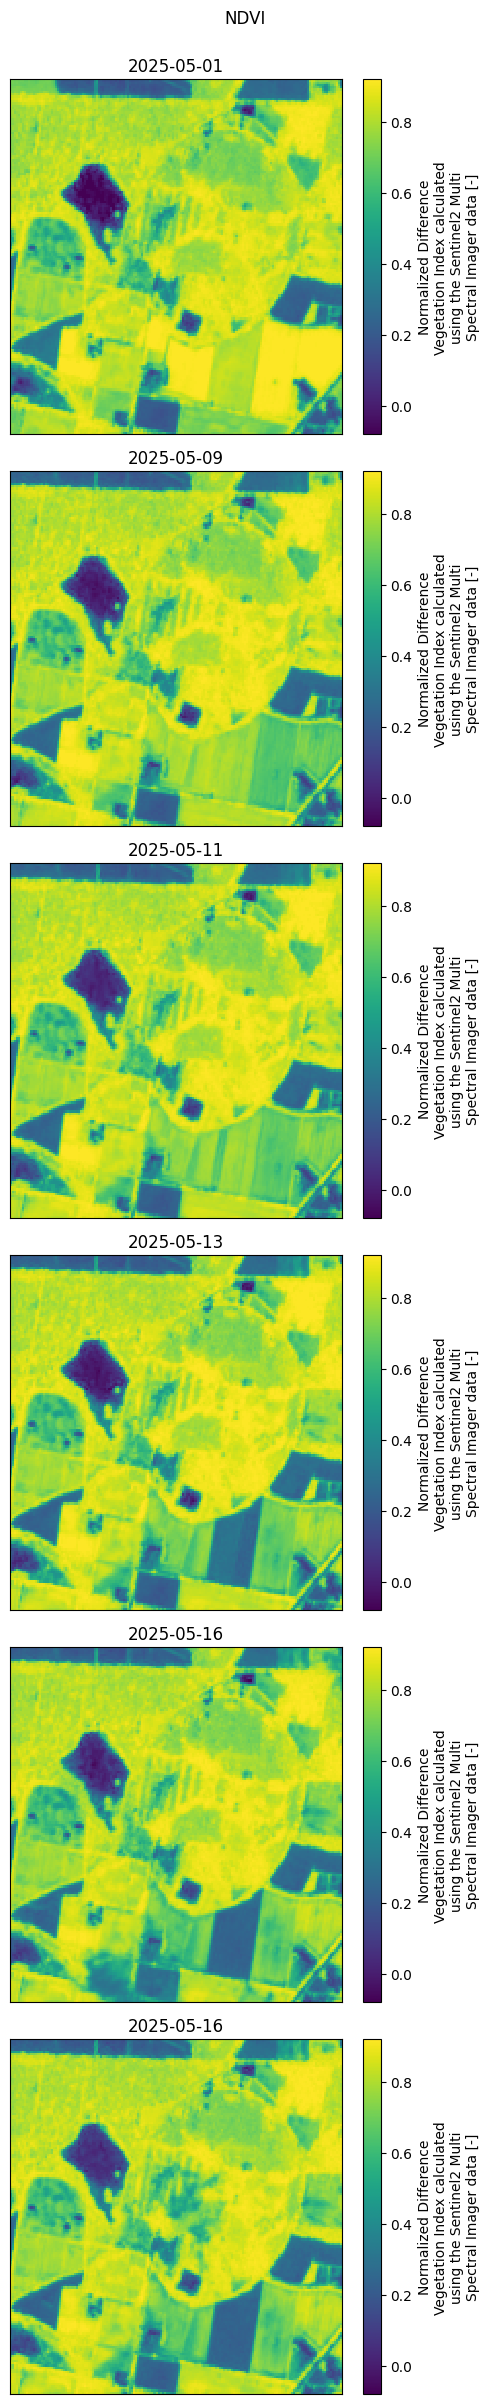

In [21]:
item_collection.items.sort(key=lambda i: i.datetime)

fig, axs = plt.subplots(len(item_collection.items), figsize=(5, 4 * len(item_collection.items)), tight_layout=True)
fig.suptitle("NDVI", y=1)

for i, item in enumerate(item_collection.items):
    asset = item.assets["NDVI"]
    with rioxarray.open_rasterio(asset.href, mask_and_scale=True) as ds:
        ds = ds.rio.clip_box(*bbox, crs="EPSG:4326")
        ds = ds.sel(band=1)
        img = ds.plot(ax=axs[i], vmin=-0.08, vmax=0.92)
        axs[i].set_title(item.datetime.date(), y=1)
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
plt.show()